In [1]:
import pandas as pd
df = pd.read_csv('UKB_olink_proteins.csv')

In [2]:
df.isnull().sum()

eid              0
ins_index        0
A1BG         10462
AAMDC        11721
AARSD1        1799
             ...  
ZNRD2        10722
ZNRF4        10740
ZP3          11721
ZP4          12132
ZPR1         11974
Length: 2925, dtype: int64

In [3]:
df.head()

,eid,ins_index,A1BG,AAMDC,AARSD1,ABCA2,ABHD14B,ABL1,ABO,ABRAXAS2,...,ZFYVE19,ZHX2,ZNF174,ZNF75D,ZNF830,ZNRD2,ZNRF4,ZP3,ZP4,ZPR1
0,1000047,0,-0.1963,1.10395,0.32815,-0.5877,0.89975,1.8328,-0.0097,1.0672,...,1.5673,0.0901,-0.3629,0.1618,0.86280,0.14515,0.0782,0.0878,-0.0335,0.0535
1,1000085,0,0.1247,-0.13955,-1.01775,0.6967,-0.07085,-0.0057,0.4181,-0.1547,...,0.0151,-0.3852,0.1575,-0.4571,0.58560,-0.06155,-0.3270,-0.0728,-0.0766,-0.1785
2,1000160,0,0.1273,0.33665,-0.29275,0.2052,0.25415,0.5727,0.3873,0.6730,...,0.7062,-0.1461,-0.1478,NaN,-0.86870,0.18465,0.0107,0.9706,-0.3426,-0.2375
3,1000174,0,-0.0786,-0.60945,-0.14010,-0.0563,-0.41380,-0.7721,1.1006,-1.0217,...,-1.1112,-0.1549,0.0642,0.2184,0.00045,-0.41040,-0.9243,0.0000,0.4606,0.0505
4,1000187,0,-0.0770,0.03435,-0.34655,-0.1289,-0.42155,-0.5341,2.7351,-0.7587,...,-0.5493,-0.2833,-0.1547,-0.1678,-0.26380,-0.23895,-0.2646,1.5654,-0.1984,-0.1828


In [4]:
import numpy as np
import pandas as pd
import pickle
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, recall_score, roc_auc_score, average_precision_score
from lightgbm import LGBMClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.calibration import calibration_curve
import operator
import warnings
warnings.filterwarnings(('ignore'))


df1= pd.read_csv('pain_onset.csv')

mydf1 = pd.merge(df, df1, how='inner', on=['eid'])

mydf1.head()


,eid,ins_index,A1BG,AAMDC,AARSD1,ABCA2,ABHD14B,ABL1,ABO,ABRAXAS2,...,ZP3,ZP4,ZPR1,head,face,neck,back,stomach,hip,knee
0,1000047,0,-0.1963,1.10395,0.32815,-0.58770,0.89975,1.8328,-0.0097,1.0672,...,0.0878,-0.0335,0.0535,0,0,1,0,0,1,0
1,1000085,0,0.1247,-0.13955,-1.01775,0.69670,-0.07085,-0.0057,0.4181,-0.1547,...,-0.0728,-0.0766,-0.1785,0,0,0,0,0,0,0
2,1000865,0,-0.0149,0.38015,0.68420,1.12055,0.53420,-0.1525,0.5340,0.0568,...,1.7281,-0.0056,2.8547,0,0,0,0,0,0,0
3,1001378,0,0.1061,0.55565,-0.03255,-0.00390,-0.06765,-0.3467,0.4166,0.7657,...,1.7189,-0.1406,1.3759,0,0,0,0,0,0,0
4,1002689,0,-0.0416,-0.77025,-0.31765,0.16510,-0.74070,-1.1400,-0.3643,-1.2282,...,1.7920,0.1499,0.8983,0,0,0,0,0,0,0


In [5]:
# 将列 A 中的 -9 替换为空缺值 NaN
mydf1['head'].replace(-9, np.nan, inplace=True)

mydf2=mydf1

mydf2.head()

# 删除列 A 中的空缺值所在行
mydf2.dropna(subset=['head'], inplace=True)

mydf2.shape

(8255, 2932)

In [6]:
import numpy as np
import pandas as pd
from sklearn.model_selection import StratifiedKFold
from collections import Counter
from lightgbm import LGBMClassifier
import warnings
warnings.filterwarnings(('ignore'))

rm_f1 = ['eid', 'ins_index']
rm_HES = ['head', 'face', 'neck', 'back', 'stomach','hip','knee']
rm_f = rm_f1 + rm_HES

X = mydf2.drop(rm_f, axis=1)
y = mydf2['head']

In [7]:
mykf = StratifiedKFold(n_splits = 5, random_state = 2022, shuffle = True)

my_params = {'n_estimators': 500,
             'max_depth': 15,
             'num_leaves': 10,
             'subsample': 0.7,
             'learning_rate': 0.01,
             'colsample_bytree': 0.7}

def normal_imp(mydict):
    mysum = sum(mydict.values())
    mykeys = mydict.keys()
    for key in mykeys:
        mydict[key] = mydict[key]/mysum
    return mydict

tg_imp_cv = Counter()
tc_imp_cv = Counter()

for train_idx, test_idx in mykf.split(X, y):
    X_train, y_train = X.iloc[train_idx,:], y.iloc[train_idx]
    my_lgb = LGBMClassifier(objective = 'binary',
                           metric = 'auc',
                           is_unbalance = True,
                           verbosity = 1, seed = 2020)
    my_lgb.set_params(**my_params)
    my_lgb.fit(X_train, y_train)
    totalgain_imp = my_lgb.booster_.feature_importance(importance_type='gain')
    totalgain_imp = dict(zip(my_lgb.booster_.feature_name(), totalgain_imp.tolist()))
    totalcover_imp = my_lgb.booster_.feature_importance(importance_type='split')
    totalcover_imp = dict(zip(my_lgb.booster_.feature_name(), totalcover_imp.tolist()))
    tg_imp_cv += Counter(normal_imp(totalgain_imp))
    tc_imp_cv += Counter(normal_imp(totalcover_imp))


tg_imp_df = pd.DataFrame({'Features': list(tg_imp_cv.keys()),
                          'TotalGain_cv': list(tg_imp_cv.values())})

tc_imp_df = pd.DataFrame({'Features': list(tc_imp_cv.keys()),
                          'TotalCover_cv': list(tc_imp_cv.values())})


#绘制特征重要程度图
ax = lgb.plot_importance(booster)
plt.show

[LightGBM] [Info] Number of positive: 132, number of negative: 6472
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.422475 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 745746
[LightGBM] [Info] Number of data points in the train set: 6604, number of used features: 2941
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.019988 -> initscore=-3.892439
[LightGBM] [Info] Start training from score -3.892439
[LightGBM] [Info] Number of positive: 132, number of negative: 6472
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.384932 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 745749
[LightGBM] [Info] Number of data points in the train set: 6604, number of used features: 2941
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.019988 -> initscore=-3.892439
[LightGBM] [Info] Start training from score -3.892439


KeyboardInterrupt: 

In [10]:
my_imp_df = pd.merge(left = tc_imp_df, right = tg_imp_df, how = 'left')
my_imp_df.sort_values(by = 'TotalGain_cv', ascending = False, inplace = True)
my_imp_df['TotalGain_cv'] = my_imp_df['TotalGain_cv']/5
my_imp_df['TotalCover_cv'] = my_imp_df['TotalCover_cv']/5


my_imp_df.head()

,Features,TotalCover_cv,TotalGain_cv
726,NRTN,0.004444,0.013871
937,SLC1A4,0.003867,0.012771
658,MB,0.002933,0.011570
990,TDGF1,0.003911,0.011018
329,EDNRB,0.003733,0.009549


In [11]:
myout=my_imp_df
myout.to_csv('result_pain/head_nm_s01.csv')

In [7]:
import numpy as np
import pandas as pd
import pickle
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, recall_score, roc_auc_score, average_precision_score
from lightgbm import LGBMClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.calibration import calibration_curve
import operator
import warnings
warnings.filterwarnings(('ignore'))

df_f = pd.read_csv('result_pain/head_s01.csv')
df_f.sort_values(by = 'TotalCover_cv', ascending = False, inplace = True)
df_f1 = df_f.head(100)
my_f = df_f1['Features'].to_list()

X = mydf2[my_f]
y = mydf2['head']

In [8]:
mykf = StratifiedKFold(n_splits = 5, random_state = 2022, shuffle = True)


my_params = {'n_estimators': 875,
             'max_depth': 16,
             'num_leaves': 11,
             'subsample': 0.7,
             'learning_rate': 0.01,
             'colsample_bytree': 0.7}


tmp_f, AUC_cv_lst= [], []

for f in my_f:
    tmp_f.append(f)
    my_X = X[tmp_f]
    AUC_cv = []
    for train_idx, test_idx in mykf.split(my_X, y):
        X_train, X_test = my_X.iloc[train_idx, :], my_X.iloc[test_idx, :]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
        my_lgb = LGBMClassifier(objective='binary',
                                metric='auc',
                                is_unbalance=True,
                                n_jobs=4,
                                verbosity=-1, seed=2022)
        my_lgb.set_params(**my_params)
        my_lgb.fit(X_train, y_train)
        y_pred_prob = my_lgb.predict_proba(X_test)[:, 1]
        AUC_cv.append(roc_auc_score(y_test, y_pred_prob))
    tmp_out = np.array([np.mean(AUC_cv), np.std(AUC_cv)] + AUC_cv)
    AUC_cv_lst.append(np.round(tmp_out, 3))
    print((f, tmp_out))

('LAIR2', array([0.52836086, 0.03965096, 0.57530809, 0.52599543, 0.51841967,
       0.56080271, 0.46127842]))
('FOLR3', array([0.53053901, 0.03188194, 0.56441735, 0.52666966, 0.5519815 ,
       0.53749485, 0.4721317 ]))
('FCAR', array([0.56574709, 0.08167522, 0.67601229, 0.44361726, 0.6039349 ,
       0.5998895 , 0.50528149]))
('PRSS2', array([0.59034536, 0.07942999, 0.64763831, 0.46374124, 0.69144473,
       0.6019122 , 0.5469903 ]))
('LILRB2', array([0.5922819 , 0.07290618, 0.67642432, 0.49926958, 0.67884032,
       0.56638386, 0.54049144]))
('SLC1A4', array([0.59529161, 0.05493089, 0.70011612, 0.55038019, 0.59795108,
       0.57165599, 0.55635465]))
('LBP', array([0.61165299, 0.06612107, 0.72465071, 0.5259767 , 0.63213095,
       0.57802375, 0.59748286]))
('TDGF1', array([0.63984343, 0.05893966, 0.74809904, 0.57862307, 0.65147769,
       0.60572349, 0.61529385]))
('NRTN', array([0.66516837, 0.04878372, 0.74570176, 0.5919579 , 0.66741581,
       0.65915646, 0.66160992]))
('HK2', arra

In [37]:
import numpy as np

# 将AUC_cv_lst转换为NumPy数组
AUC_cv_array = np.array(AUC_cv_lst)

# 存储每次bootstrap迭代的AUC
AUC_bootstrap = []

# 执行1,000次bootstrap迭代
num_iterations = 1000

for _ in range(num_iterations):
    # 从AUC_cv_array中随机抽取样本进行bootstrap
    bootstrap_sample = np.random.choice(AUC_cv_array.ravel(), size=len(AUC_cv_array), replace=True)
    
    # 计算每次bootstrap迭代的AUC中位数
    median_auc_bootstrap = np.median(bootstrap_sample)
    AUC_bootstrap.append(median_auc_bootstrap)

# 计算整体中位数和95%置信区间
overall_median_auc = np.median(AUC_bootstrap)
ci_auc = np.percentile(AUC_bootstrap, [2.5, 97.5])

# 输出结果
print("整体AUC 中位数:", overall_median_auc)
print("整体AUC 95% 置信区间:", ci_auc)

整体AUC 中位数: 0.769
整体AUC 95% 置信区间: [0.7519875 0.7825   ]


In [8]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt
import numpy as np
from lightgbm import LGBMClassifier
from sklearn.model_selection import StratifiedKFold

# 假设 my_X 为特征数据，y 为标签数据，my_params 为模型参数
mykf = StratifiedKFold(n_splits = 5, random_state = 2022, shuffle = True)
my_params = {'n_estimators': 1000,
             'max_depth': 5,
             'num_leaves': 30,
             'subsample': 0.7,
             'learning_rate': 0.01,
             'colsample_bytree': 0.7}

tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)

# 循环遍历特征数据
for train_idx, test_idx in mykf.split(X, y):
    X_train, X_test = X.iloc[train_idx, :], X.iloc[test_idx, :]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
    my_lgb = LGBMClassifier(objective='binary', metric='auc', is_unbalance=True, n_jobs=4, verbosity=-1, seed=2022)
    my_lgb.set_params(**my_params)
    my_lgb.fit(X_train, y_train)
    y_pred_prob = my_lgb.predict_proba(X_test)[:, 1]
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
    tprs.append(np.interp(mean_fpr, fpr, tpr))
    tprs[-1][0] = 0.0
    roc_auc = roc_auc_score(y_test, y_pred_prob)
    aucs.append(roc_auc)

# 计算平均的ROC曲线和AUC值
mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = np.mean(aucs)
std_auc = np.std(aucs)

# 绘制平均的ROC曲线
plt.plot(mean_fpr, mean_tpr, color='b', label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc), lw=2)
plt.plot([0, 1], [0, 1], color='k', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic Curve')
plt.legend(loc="lower right")
plt.show()

tprs_upper = np.minimum(mean_tpr + 2*std_auc, 1)
tprs_lower = mean_tpr - 2*std_auc

plt.plot(mean_fpr,  mean_tpr, 'blue', linewidth = 2,
         label = 'dementia all-time')
plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color = 'lightskyblue', alpha = 0.2)




plt.plot([0, 1], [0, 1], 'r--')
plt.xlim([-0.0, 1.0])
plt.ylim([-0.0, 1.0])
plt.ylabel('True Positive Rate', fontsize = 20)
plt.xlabel('False Positive Rate', fontsize = 20)

plt.yticks([0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0], fontsize = 16)
plt.xticks([0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0], fontsize = 16)
plt.grid(which='minor', alpha=0.2, linestyle=':')
plt.grid(which='major', alpha=0.5,  linestyle='--')
plt.tight_layout()

In [ ]:
import lightgbm as lgb

# 看看gbdt对各个特征的重视程度
lgb.plot_importance(my_lgb,importance_type='TotalCover_cv')

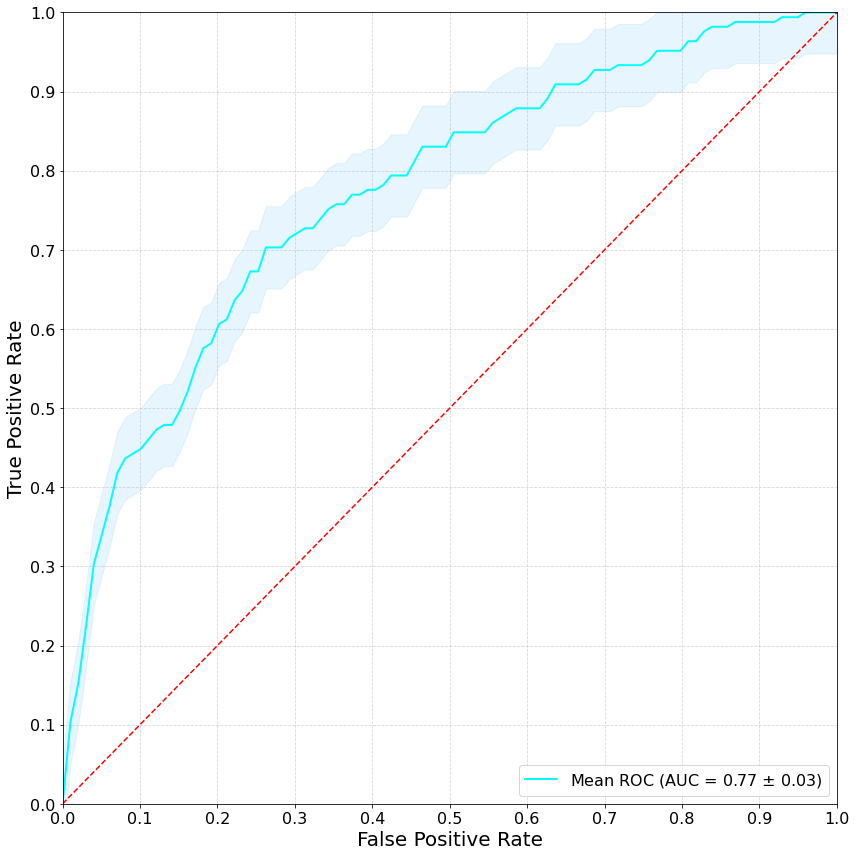

In [21]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt
import numpy as np
from lightgbm import LGBMClassifier
from sklearn.model_selection import StratifiedKFold

plt.figure(figsize = (12, 12))

# 假设 my_X 为特征数据，y 为标签数据，my_params 为模型参数
mykf = StratifiedKFold(n_splits = 5, random_state = 2022, shuffle = True)
my_params = {'n_estimators': 1000,
             'max_depth': 5,
             'num_leaves': 30,
             'subsample': 0.7,
             'learning_rate': 0.01,
             'colsample_bytree': 0.7}

tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)

# 循环遍历特征数据
for train_idx, test_idx in mykf.split(X, y):
    X_train, X_test = X.iloc[train_idx, :], X.iloc[test_idx, :]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
    my_lgb = LGBMClassifier(objective='binary', metric='auc', is_unbalance=True, n_jobs=4, verbosity=-1, seed=2022)
    my_lgb.set_params(**my_params)
    my_lgb.fit(X_train, y_train)
    y_pred_prob = my_lgb.predict_proba(X_test)[:, 1]
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
    tprs.append(np.interp(mean_fpr, fpr, tpr))
    tprs[-1][0] = 0.0
    roc_auc = roc_auc_score(y_test, y_pred_prob)
    aucs.append(roc_auc)

# 计算平均的ROC曲线和AUC值
mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = np.mean(aucs)
std_auc = np.std(aucs)


tprs_upper = np.minimum(mean_tpr + 2*std_auc, 1)
tprs_lower = mean_tpr - 2*std_auc

plt.plot(mean_fpr,  mean_tpr, 'cyan', linewidth = 2,label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc))
plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color = 'lightskyblue', alpha = 0.2)

plt.legend(loc="lower right",fontsize = 16)


plt.plot([0, 1], [0, 1], 'r--')
plt.xlim([-0.0, 1.0])
plt.ylim([-0.0, 1.0])
plt.ylabel('True Positive Rate', fontsize = 20)
plt.xlabel('False Positive Rate', fontsize = 20)

plt.yticks([0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0], fontsize = 16)
plt.xticks([0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0], fontsize = 16)
plt.grid(which='minor', alpha=0.2, linestyle=':')
plt.grid(which='major', alpha=0.5,  linestyle='--')
plt.tight_layout()
plt.savefig('result_pain/ROC_head.png')

In [20]:
plt.savefig('result_pain/ROC_head.png')

<Figure size 432x288 with 0 Axes>

In [15]:
AUC_df = pd.concat((pd.DataFrame({'Features':tmp_f}), pd.DataFrame(AUC_cv_lst)), axis = 1)

AUC_df.head()

myout2=AUC_df

myout2.columns = ['Features', 'AUC_mean', 'AUC_std', 'AUC0', 'AUC1', 'AUC2', 'AUC3', 'AUC4']

myout2.tail()

,Features,AUC_mean,AUC_std,AUC0,AUC1,AUC2,AUC3,AUC4
95,CEACAM3,0.821,0.021,0.848,0.814,0.787,0.818,0.838
96,RLN2,0.825,0.021,0.851,0.824,0.788,0.826,0.836
97,ACHE,0.821,0.024,0.855,0.828,0.780,0.823,0.817
98,FCGR2A,0.816,0.022,0.843,0.823,0.775,0.817,0.823
99,TFF1,0.819,0.017,0.845,0.816,0.794,0.814,0.826


In [23]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint as sp_randint

# 定义要调整的超参数和相应的取值范围
param_dist = {
    'n_estimators': sp_randint(500, 1000),
    'max_depth': sp_randint(5, 20),
    'num_leaves': sp_randint(10, 30)
}

# 创建要优化的模型对象
model = LGBMClassifier()  

# 创建随机搜索对象
random_search = RandomizedSearchCV(estimator=model, param_distributions=param_dist, scoring='roc_auc', n_iter=10, cv=5)

# 执行随机搜索
random_search.fit(X, y)

# 打印最佳超参数组合和最佳得分
print("Best Hyperparameters: ", random_search.best_params_)
print("Best Score: ", random_search.best_score_)

[LightGBM] [Info] Number of positive: 132, number of negative: 6472
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003324 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 25251
[LightGBM] [Info] Number of data points in the train set: 6604, number of used features: 100
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.019988 -> initscore=-3.892439
[LightGBM] [Info] Start training from score -3.892439
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

In [16]:
myout2.to_csv('result_pain/head_nm_s03.csv')

In [15]:
df_f2 = df_f.head(50)
df_f2.to_csv('result_pain/head_nm_s001.csv')

df_f3 = pd.read_csv('result_pain/head_nm_s03.csv')
df_f3 = df_f3.head(50)
df_f3.shape
df_f3.to_csv('result_pain/head_nm_s002.csv')

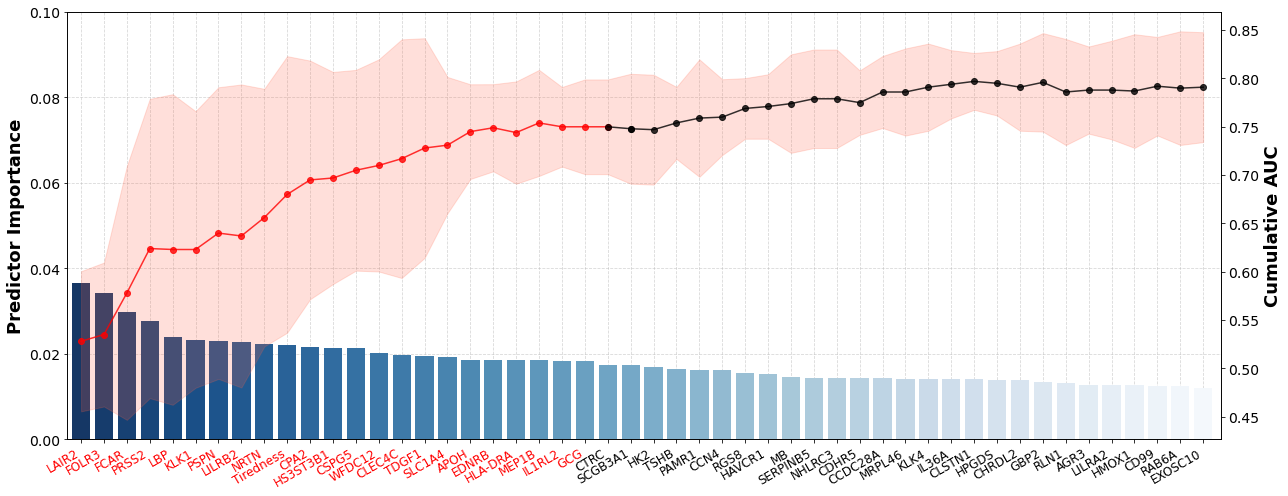

In [16]:
import numpy as np
import pandas as pd
from sklearn.model_selection import StratifiedKFold
from lightgbm import LGBMClassifier
import lightgbm as lgb
import matplotlib.pyplot as plt
import seaborn as sns


fimp_s03 = pd.read_csv('result_pain/head_nm_s001.csv')
fimp_s03.sort_values(by = 'TotalCover_cv', ascending = False, inplace = True)
fimp_s04 = pd.read_csv('result_pain/head_nm_s002.csv')
fimp_s04['f_idx'] = fimp_s04['Unnamed: 0'] + 1
mylabel = (fimp_s03['Features'])

fimp_tc = pd.DataFrame(zip(fimp_s03['TotalCover_cv'], mylabel), columns=['Fimp','Feature'])
fimp_tc = pd.concat((fimp_s04[['f_idx', 'AUC_mean', 'AUC0', 'AUC1', 'AUC2', 'AUC3', 'AUC4', 'AUC_std']], fimp_tc), axis = 1)
fimp_tc['AUC_lower'] = fimp_tc['AUC_mean'] - 1.96*fimp_tc['AUC_std']
fimp_tc['AUC_upper'] = fimp_tc['AUC_mean'] + 1.96*fimp_tc['AUC_std']

fig, ax = plt.subplots(figsize = (18, 7))
palette = sns.color_palette("Blues",n_colors=len(fimp_tc))
palette.reverse()
sns.barplot(ax=ax, x = "Feature", y = "Fimp", palette=palette, data=fimp_tc.sort_values(by="Fimp", ascending=False))
ax.set_ylim([0, 0.1])
ax.tick_params(axis='y', labelsize=14)
ax.set_xticklabels(fimp_tc['Feature'], rotation=30, fontsize=12, horizontalalignment='right')
nb_f = 23
my_col = ['r']*nb_f + ['k']*(len(fimp_tc)-nb_f)
for ticklabel, tickcolor in zip(plt.gca().get_xticklabels(), my_col):
    ticklabel.set_color(tickcolor)
ax.set_ylabel('Predictor Importance', weight='bold', fontsize=18)
#ax.set_title('10-year incident AD', y=1.0, pad=-25, weight='bold', fontsize=24)
ax.set_xlabel('')
ax.grid(which='minor', alpha=0.2, linestyle=':')
ax.grid(which='major', alpha=0.5,  linestyle='--')
ax.set_axisbelow(True)

ax2 = ax.twinx()
#ax2.plot(fimp_tc['f_idx']-1, fimp_tc['AUC0'], 'mediumvioletred', alpha = 0.15, marker='o')
#ax2.plot(fimp_tc['f_idx']-1, fimp_tc['AUC1'], 'mediumvioletred', alpha = 0.15, marker='o')
#ax2.plot(fimp_tc['f_idx']-1, fimp_tc['AUC2'], 'mediumvioletred', alpha = 0.15, marker='o')
#ax2.plot(fimp_tc['f_idx']-1, fimp_tc['AUC3'], 'mediumvioletred', alpha = 0.15, marker='o')
#ax2.plot(fimp_tc['f_idx']-1, fimp_tc['AUC4'], 'mediumvioletred', alpha = 0.15, marker='o')
ax2.plot(np.arange(nb_f+1), fimp_tc['AUC_mean'][:nb_f+1], 'red', alpha = 0.8, marker='o')
ax2.plot(np.arange(nb_f+1, len(fimp_tc)), fimp_tc['AUC_mean'][nb_f+1:], 'black', alpha = 0.8, marker='o')
ax2.plot([nb_f, nb_f+1], fimp_tc['AUC_mean'][nb_f:nb_f+2], 'black', alpha = 0.8, marker='o')
plt.fill_between(fimp_tc['f_idx']-1, fimp_tc['AUC_lower'], fimp_tc['AUC_upper'], color = 'tomato', alpha = 0.2)
ax2.set_ylabel('Cumulative AUC', weight='bold', fontsize=18)
ax2.tick_params(axis='y', labelsize=14)
#ax2.set_yticklabels([0.78, 0.80, 0.82, 0.84, 0.86], fontsize=14)
fig.tight_layout()
plt.xlim([-.6, len(fimp_tc)-.2])
plt.savefig('result_pain/Cover_Imp_head_nm.png')